
# The structure of this jupyter notebook:
1. Load model
2. Solve model
3. Simulate model
4. Plot model results 

    i. Average over age

    ii. All simulation over age

    iii. Solutions for each grid point over age (2D)
    
    iV. solutions for specific grid points in 3D

5. Welfare analysis
     
    i. Replacement rate

    ii. Consumption replacement rate

    iii. Consumption equivalence

# Load model 

In [1]:
%load_ext autoreload
%autoreload 2
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits import mplot3d
from mpl_toolkits.mplot3d import Axes3D
from WelfareMeasures import *
from functions_njit import tax_rate_fct
from bernoulli_distribution import Bernoulli
from help_functions_non_njit import *
# load local model file and initialize model class
from model import ModelClass

In [2]:
model = ModelClass() # set a few number of periods.

par = model.par
sol = model.sol
sim = model.sim

c:\Users\peter\Desktop\Speciale\Design_retirement\model.py:135: RuntimeWarning: invalid value encountered in divide
  np.cumsum(S[::-1])[::-1] / S,


# Solve model

In [3]:
par.opt_tol = 1e-6
par.opt_maxiter = 1000

%time model.solve(do_print=False)

CPU times: total: 8min 6s
Wall time: 1min 24s



# Simulate model

In [4]:
%time model.simulate()

CPU times: total: 37.3 s
Wall time: 28.6 s


# Plot model results

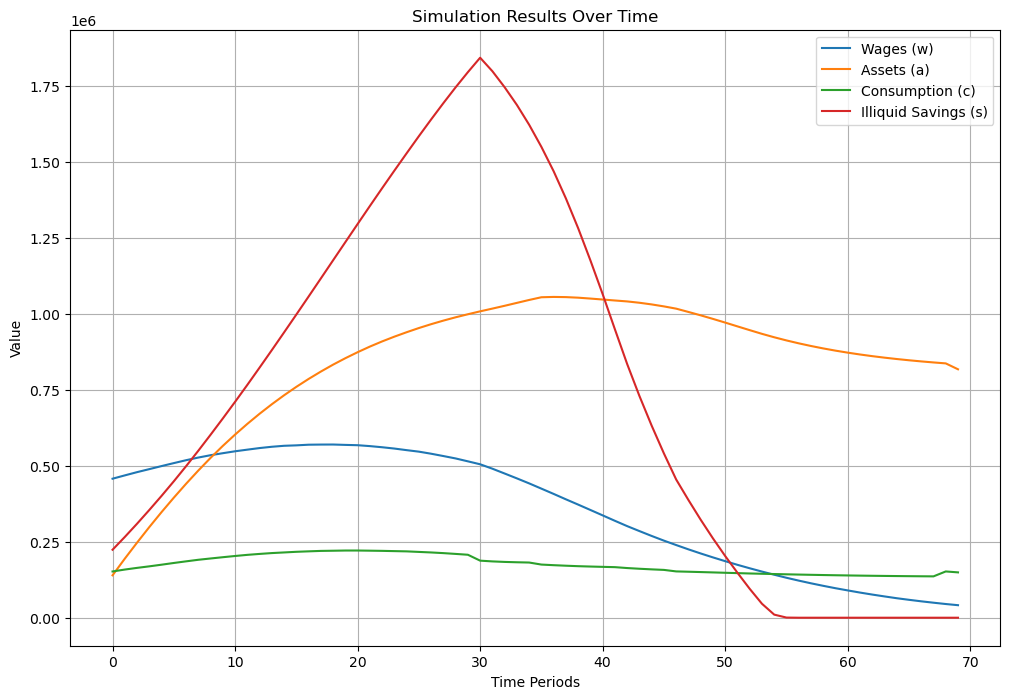

C:\Users\peter\AppData\Local\Temp\ipykernel_6296\2078573338.py:38: RuntimeWarning: Mean of empty slice
  "Hours (hours)": np.nanmean(np.where(model.sim.ex == 1, model.sim.h, np.nan),axis=0),
C:\Users\peter\AppData\Local\Temp\ipykernel_6296\2078573338.py:43: RuntimeWarning: Mean of empty slice
  "Tax rate (tax_rate)": np.nanmean(np.where(model.sim.ex == 1, model.sim.tax_rate, np.nan),axis=0),


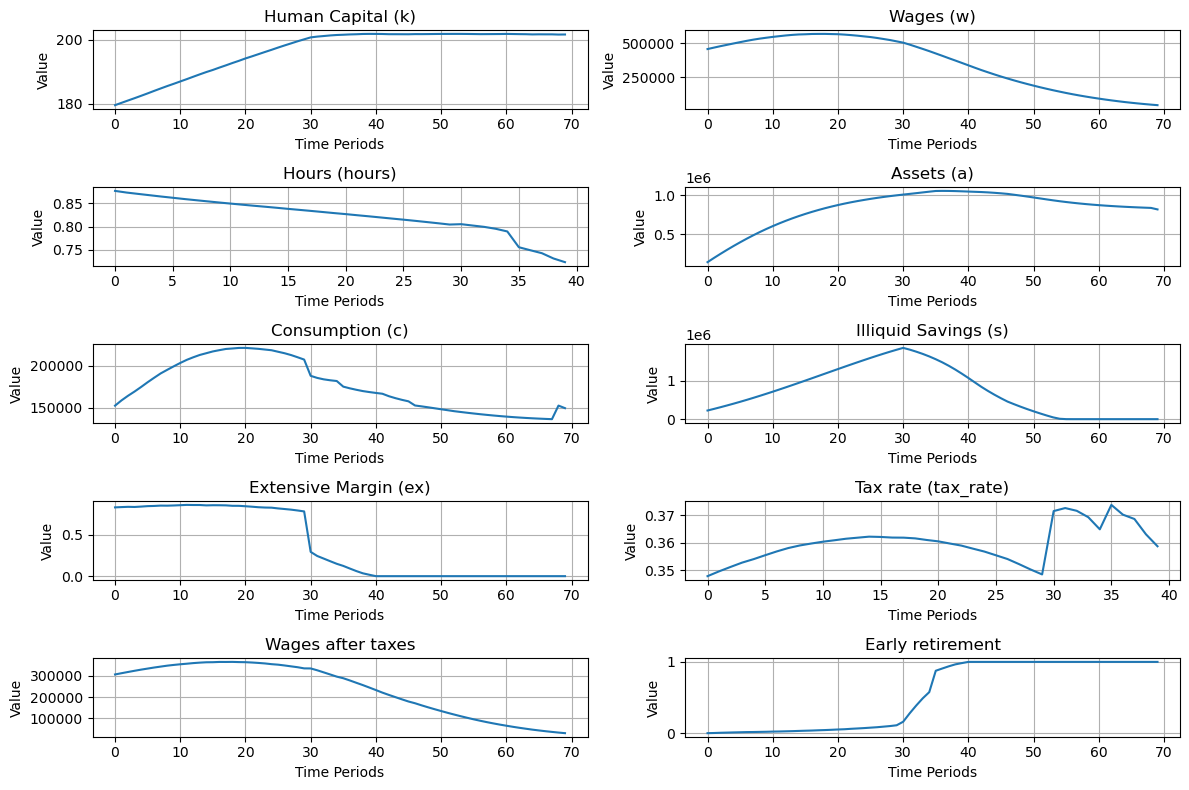

In [5]:
time = np.arange(par.T)

simulated_data = {
    "Wages (w)": np.mean(model.sim.w[:], axis=0),
    "Assets (a)": np.mean(model.sim.a[:], axis=0),
    "Consumption (c)": np.mean(model.sim.c[:], axis=0),
    "Illiquid Savings (s)": np.mean(model.sim.s[:], axis=0),
}

# Create a figure and plot each variable
plt.figure(figsize=(12, 8))
for label, data in simulated_data.items():
    plt.plot(time, data, label=label)

# Formatting
plt.xlabel("Time Periods")
plt.ylabel("Value")
plt.title("Simulation Results Over Time")
plt.legend()
plt.grid(True)

# Show plot
plt.show()
# Create a 3x2 grid of subplots
fig, axes = plt.subplots(5, 2, figsize=(12, 8))

# Titles for the plots
titles = [
    "Human Capital (k)", "Wages (w)", "Hours (hours)", 
    "Assets (a)", "Consumption (c)", "Illiquid Savings (s)"
]

# Generate example data (replace with actual values)
time = np.arange(par.T)
data_dict = {
    "Human Capital (k)": np.mean(model.sim.k[:], axis=0),
    "Wages (w)": np.mean(model.sim.w[:], axis=0),
    "Hours (hours)": np.nanmean(np.where(model.sim.ex == 1, model.sim.h, np.nan),axis=0),
    "Assets (a)": np.mean(model.sim.a[:], axis=0),
    "Consumption (c)": np.mean(model.sim.c[:], axis=0),
    "Illiquid Savings (s)": np.mean(model.sim.s[:], axis=0),
    "Extensive Margin (ex)": np.mean(model.sim.ex[:], axis=0),
    "Tax rate (tax_rate)": np.nanmean(np.where(model.sim.ex == 1, model.sim.tax_rate, np.nan),axis=0),
    "Wages after taxes": np.mean((1-model.sim.tax_rate[:,:])*model.sim.w[:,:], axis=0),
    "Early retirement":np.sum([model.sim.e[i,:] == 2.0 for i in range(model.sim.e.shape[0])], axis=0) / model.sim.e.shape[0],
}
# Plot each variable in its respective subplot
for ax, (label, data) in zip(axes.flatten(), data_dict.items()):
    ax.plot(time, data)
    ax.set_title(label)
    ax.set_xlabel("Time Periods")
    ax.set_ylabel("Value")
    ax.grid(True)

# Adjust layout to prevent overlap
plt.tight_layout()
plt.show()


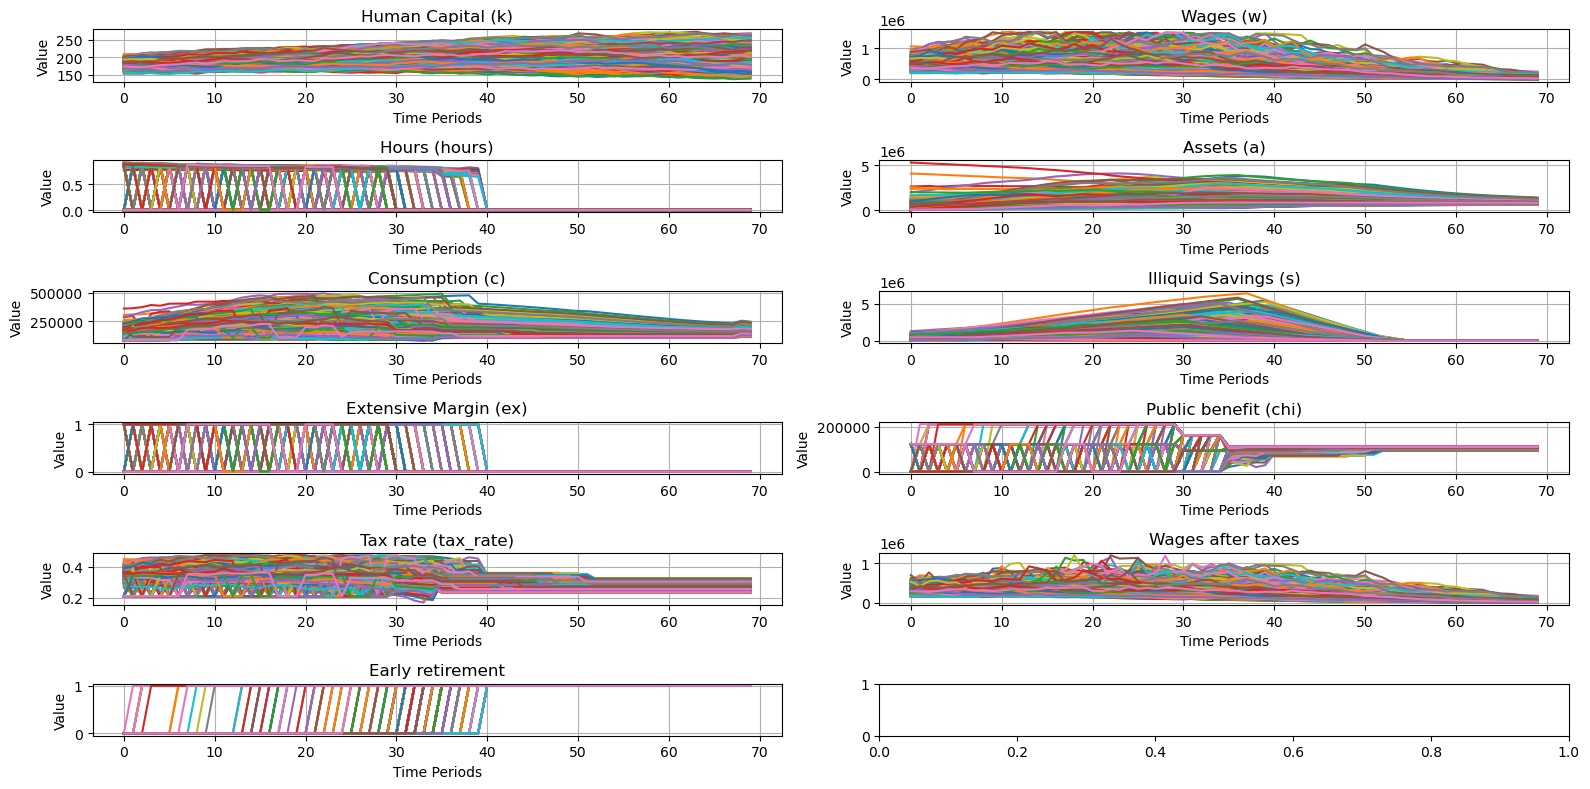

In [6]:
# Create a 3x2 grid of subplots
fig, axes = plt.subplots(6, 2, figsize=(16, 8))

# Titles for the plots
titles = [
    "Human Capital (k)", "Wages (w)", "Hours (hours)", 
    "Assets (a)", "Consumption (c)", "Illiquid Savings (s)"
]

t_end = par.T
# Generate example data (replace with actual values)
time = np.arange(t_end)
for i in np.arange(13, 1000):
    data_dict = {
        "Human Capital (k)": model.sim.k[i,:t_end],
        "Wages (w)": model.sim.w[i,:t_end],
        "Hours (hours)": model.sim.h[i,:t_end],
        "Assets (a)": model.sim.a[i,:t_end],
        "Consumption (c)": model.sim.c[i,:t_end],
        "Illiquid Savings (s)": model.sim.s[i,:t_end],
        "Extensive Margin (ex)": model.sim.ex[i,:t_end],
        "Public benefit (chi)": model.sim.chi_payment[i,:t_end],
        "Tax rate (tax_rate)": model.sim.tax_rate[i,:t_end],
        "Wages after taxes": (1-model.sim.tax_rate[i,:t_end])*model.sim.w[i,:t_end],
        "Early retirement": model.sim.e[i,:t_end] == 2.0,
    }
    # Plot each variable in its respective subplot
    for ax, (label, data) in zip(axes.flatten(), data_dict.items()):
        ax.plot(time, data)
        ax.set_title(label)
        ax.set_xlabel("Time Periods")
        ax.set_ylabel("Value")
        ax.grid(True)

# Adjust layout to prevent overlap
plt.tight_layout()
plt.show()

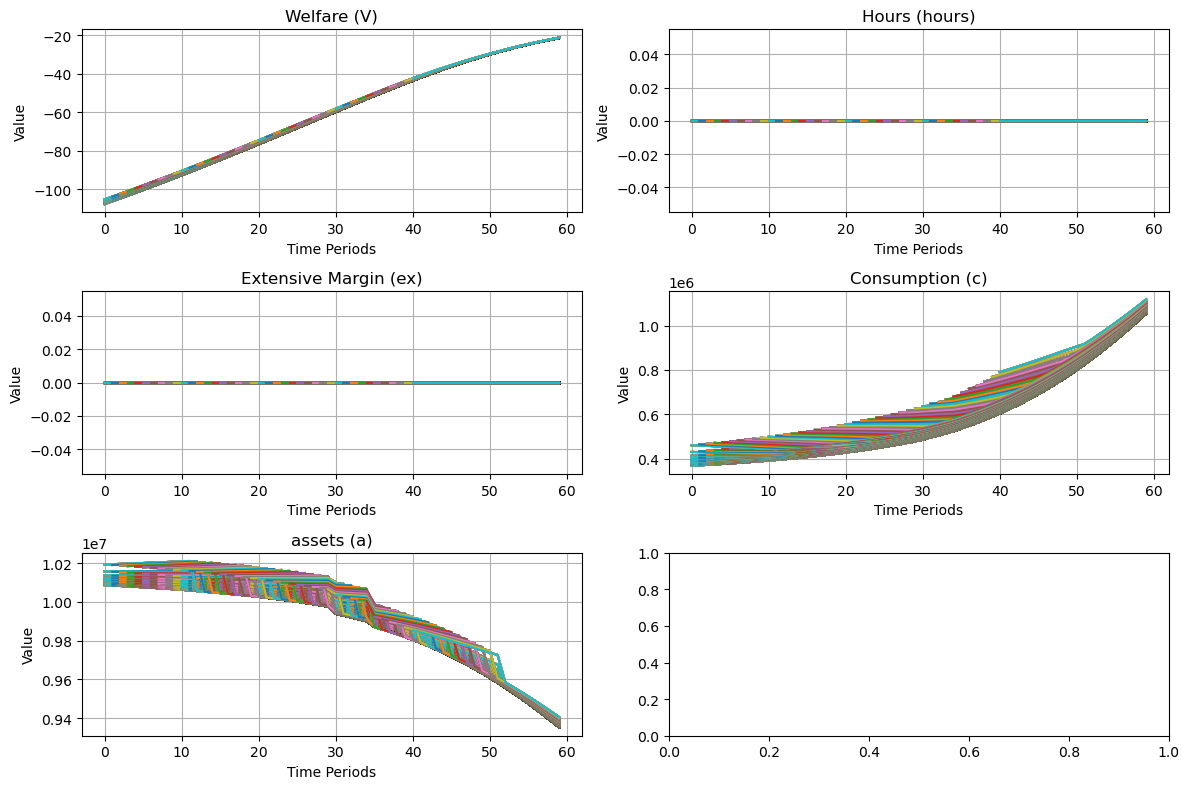

In [7]:
# Create a 3x2 grid of subplots
fig, axes = plt.subplots(3, 2, figsize=(12, 8))

# Titles for the plots
titles = [
    "Human Capital (k)", "Wages (w)", "Hours (hours)", 
    "Assets (a)", "Consumption (c)", "Illiquid Savings (s)"
]

t_end = 60

# Generate example data (replace with actual values)
time = np.arange(t_end)
for s in range(par.N_s):
    for k in range(par.N_k):
        for a in range(par.N_a):
            for e in range(len(par.e_grid)):
                data_dict = {
                    "Welfare (V)": model.sol.V[:t_end,a,s,k,:,2],
                    "Hours (hours)": model.sol.h[:t_end,a,s,k,:,2],
                    "Extensive Margin (ex)": model.sol.ex[:t_end,a,s,k,:,2],
                    "Consumption (c)": model.sol.c[:t_end,a,s,k,:,2],  
                    "assets (a)": model.sol.a[:t_end,a,s,k,:,2],                   
                }
    # Plot each variable in its respective subplot
        for ax, (label, data) in zip(axes.flatten(), data_dict.items()):
            ax.plot(time, data)
            ax.set_title(label)
            ax.set_xlabel("Time Periods")
            ax.set_ylabel("Value")
            ax.grid(True)

# Adjust layout to prevent overlap
plt.tight_layout()
plt.show()

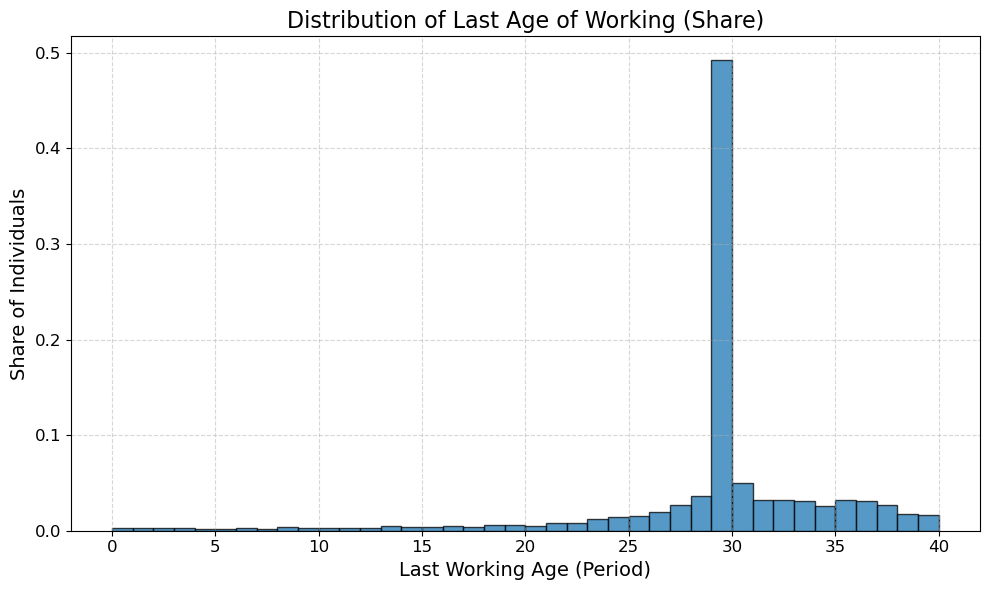

In [8]:
# 1. Find last time ex == 1 for each individual
last_working = np.full(sim.ex.shape[0], np.nan)  # initialize

for i in range(sim.ex.shape[0]):
    working = np.where(sim.ex[i, :] == 1)[0]  # find where ex=1
    if working.size > 0:
        last_working[i] = working[-1]  # last time they worked (take last index)

# 2. Plot the histogram
plt.figure(figsize=(10, 6))

# Define bins
bins = range(int(np.nanmin(last_working)), int(np.nanmax(last_working)) + 2)

# Normalize histogram to show shares
plt.hist(last_working, bins=bins, edgecolor='black', alpha=0.75,
         weights=np.ones_like(last_working) / np.sum(~np.isnan(last_working)))

# Aesthetic enhancements
plt.title("Distribution of Last Age of Working (Share)", fontsize=16)
plt.xlabel("Last Working Age (Period)", fontsize=14)
plt.ylabel("Share of Individuals", fontsize=14)
plt.grid(True, linestyle='--', alpha=0.5)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.tight_layout()

plt.show()


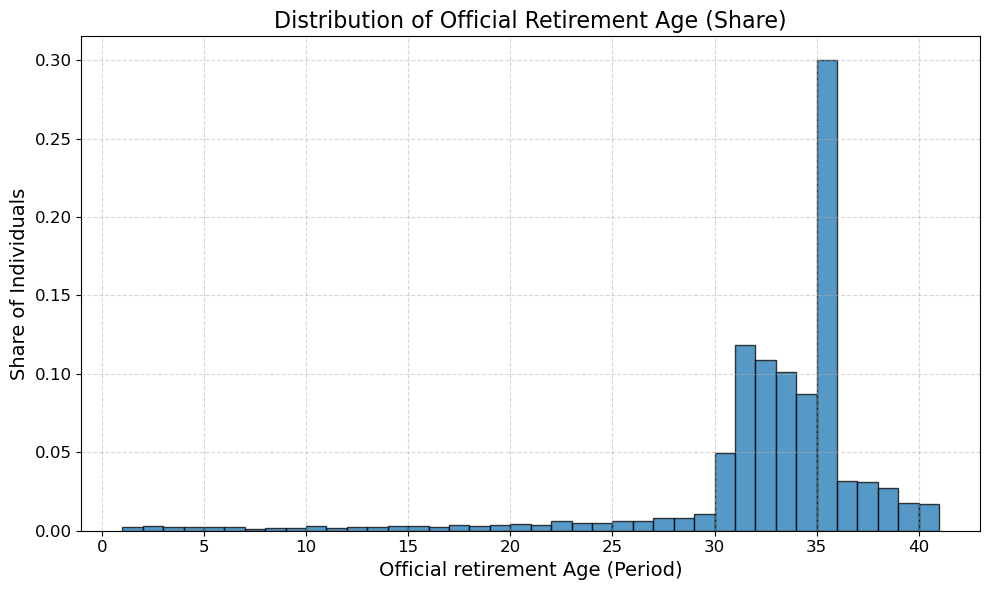

In [9]:
# 1. Find first time e == 2 for each individual
first_retirement = np.full(sim.e.shape[0], np.nan)  # initialize

for i in range(sim.e.shape[0]):
    retired = np.where(sim.e[i, :] == 2)[0]  # find where e=2
    if retired.size > 0:
        first_retirement[i] = retired[0]  # first time they retire

# 2. Plot the histogram
plt.figure(figsize=(10, 6))

# Define bins
bins = range(int(np.nanmin(first_retirement)), int(np.nanmax(first_retirement)) + 2)  # +2 to include last bin

# Normalize histogram to show shares
plt.hist(first_retirement, bins=bins, edgecolor='black', alpha=0.75,
         weights=np.ones_like(first_retirement) / np.sum(~np.isnan(first_retirement)))

# Aesthetic stuff
plt.title("Distribution of Official Retirement Age (Share)", fontsize=16)
plt.xlabel("Official retirement Age (Period)", fontsize=14)
plt.ylabel("Share of Individuals", fontsize=14)
plt.grid(True, linestyle='--', alpha=0.5)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.tight_layout()

plt.show()


In [22]:
# To help find nan values
if np.isnan(sim.c).any():
    count = 0 
    list_of_nan = []
    for i in range(sim.c.shape[0]):
        if np.isnan(sim.c[i,35]):
            print(i)
            list_of_nan.append(i)
            count +=1
    # Create a 3x2 grid of subplots
    fig, axes = plt.subplots(6, 2, figsize=(12, 8))

    # Titles for the plots
    titles = [
        "Human Capital (k)", "Wages (w)", "Hours (hours)", 
        "Assets (a)", "Consumption (c)", "Illiquid Savings (s)"
    ]

    t_end = par.T 
    # Generate example data (replace with actual values)
    time = np.arange(t_end)
    for i in list_of_nan[:3]:
        data_dict = {
            "Human Capital (k)": model.sim.k[i,:t_end],
            "Wages (w)": model.sim.w[i,:t_end],
            "Hours (hours)": model.sim.h[i,:t_end],
            "Assets (a)": model.sim.a[i,:t_end],
            "Consumption (c)": model.sim.c[i,:t_end],
            "Illiquid Savings (s)": model.sim.s[i,:t_end],
            "Extensive Margin (ex)": model.sim.ex[i,:t_end],
            "Public benefit (chi)": model.sim.chi_payment[i,:t_end],
            "Tax rate (tax_rate)": model.sim.tax_rate[i,:t_end],
            "Wages after taxes": (1-model.sim.tax_rate[i,:t_end])*model.sim.w[i,:t_end],
            "Early retirement": np.sum([model.sim.e[i,:t_end] == 2.0 for i in range(model.sim.e.shape[0])], axis=0) / model.sim.e.shape[0],
        }
        # Plot each variable in its respective subplot
        for ax, (label, data) in zip(axes.flatten(), data_dict.items()):
            ax.plot(time, data)
            ax.set_title(label)
            ax.set_xlabel("Time Periods")
            ax.set_ylabel("Value")
            ax.grid(True)

    # Adjust layout to prevent overlap
    plt.tight_layout()
    plt.show()
    print('Antal der fejler ',count)

In [23]:
assert False

AssertionError: 

# Welfare, 
1. Replacement rate
2. Consumption replacement rate
3. Calculate consumption equivalence

In [ ]:
replacement_rate = replacement_rate_fct(model)
# Create the histogram
plt.figure(figsize=(8, 5))  # Set the figure size
plt.hist(replacement_rate, bins=30, color='skyblue', edgecolor='black')

# Add titles and labels
plt.title("Replacement Rate Distribution")
plt.xlabel("Replacement Rate")
plt.ylabel("Frequency")
plt.grid(axis='y', linestyle='--', alpha=0.7)  # Add a light grid for better visualization

# Display the histogram
plt.show()

In [ ]:
# calculate consumption replacement rate
consumption_replacement_rate = consumption_replacement_rate_fct(model)
# Create the histogram
plt.figure(figsize=(8, 5))  # Set the figure size
plt.hist(consumption_replacement_rate, bins=30, color='skyblue', edgecolor='black')

# Add titles and labels
plt.title("Consumption replacement Rate Distribution")
plt.xlabel("Consumption replacement Rate")
plt.ylabel("Frequency")
plt.grid(axis='y', linestyle='--', alpha=0.7)  # Add a light grid for better visualization

# Display the histogram
plt.show()

In [ ]:
# Change parameters and re-solve
# theta = [1.0]
# theta_names = ['alpha_f0']

# theta = [36]
# theta_names = ['retirement_age']

theta = [0.03]
theta_names = ['r_a']


og_model, new_model =  make_new_model(model, theta, theta_names, do_print = False)


In [ ]:
# Compare models 
consumption_eq = find_consumption_equivalence(og_model, new_model, do_print= True, the_method = 'brentq')
intensive_margin, extensive_margin, intensive_margin_age, extensive_margin_age = labor_elasticity(og_model, new_model)

# Labor supply analysis
ages = np.arange(par.start_age, par.start_age+len(intensive_margin_age))
# First plot: Intensive Margin by Age
plt.figure(figsize=(10, 6))
plt.plot(ages, intensive_margin_age, linewidth=2, label="Age-specific Intensive Margin")
plt.axhline(0, color='black', linestyle='--', linewidth=1)
plt.axhline(intensive_margin, color='red', linestyle='-', linewidth=1, label="Average Intensive Margin")
plt.xlabel("Age", fontsize=14)
plt.ylabel("Intensive Margin, percent", fontsize=14)
plt.grid(True, linestyle='--', alpha=0.6)
plt.tight_layout()
plt.legend()
plt.show()

# Second plot: Extensive Margin by Age
plt.figure(figsize=(10, 6))
plt.plot(ages, extensive_margin_age, linewidth=2, label="Age-specific extensive Margin")
plt.title("Extensive Margin by Age", fontsize=16)
plt.axhline(0, color='black', linestyle='--', linewidth=1)  # Horizontal line at 0
plt.axhline(extensive_margin, color='red', linestyle='-', linewidth=1, label="Average Extensive Margin")
plt.xlabel("Age", fontsize=14)
plt.ylabel("Extensive Margin, percent point", fontsize=14)
plt.grid(True, linestyle='--', alpha=0.6)
plt.tight_layout()
plt.legend()
plt.show()

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# Time array
time = np.arange(par.T)

# Data for selected summary variables
summary_vars = ["Wages (w)", "Assets (a)", "Consumption (c)", "Illiquid Savings (s)"]
simulated_data_new = {
    "Wages (w)": np.mean(new_model.sim.w[:], axis=0),
    "Assets (a)": np.mean(new_model.sim.a[:], axis=0),
    "Consumption (c)": np.mean(new_model.sim.c[:], axis=0),
    "Illiquid Savings (s)": np.mean(new_model.sim.s[:], axis=0),
}
simulated_data_og = {
    "Wages (w)": np.mean(og_model.sim.w[:], axis=0),
    "Assets (a)": np.mean(og_model.sim.a[:], axis=0),
    "Consumption (c)": np.mean(og_model.sim.c[:], axis=0),
    "Illiquid Savings (s)": np.mean(og_model.sim.s[:], axis=0),
}

# Plot summary variables with matching colors
plt.figure(figsize=(12, 8))
color_cycle = plt.rcParams['axes.prop_cycle'].by_key()['color']

for idx, label in enumerate(summary_vars):
    color = color_cycle[idx % len(color_cycle)]
    plt.plot(time, simulated_data_og[label], linestyle='-', label=f"{label} (original)", color=color)
    plt.plot(time, simulated_data_new[label], linestyle='--', label=f"{label} (new)", color=color)

# Formatting
plt.xlabel("Time Periods")
plt.ylabel("Value")
plt.title("Simulation Results Over Time")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# ---------- MULTIPLE SUBPLOTS COMPARISON -----------

# Full variable set
data_dict_new = {
    "Human Capital (k)": np.mean(new_model.sim.k[:], axis=0),
    "Wages (w)": np.mean(new_model.sim.w[:], axis=0),
    "Hours (hours)": np.nanmean(np.where(new_model.sim.ex == 1, new_model.sim.h, np.nan), axis=0),
    "Assets (a)": np.mean(new_model.sim.a[:], axis=0),
    "Consumption (c)": np.mean(new_model.sim.c[:], axis=0),
    "Illiquid Savings (s)": np.mean(new_model.sim.s[:], axis=0),
    "Extensive Margin (ex)": np.mean(new_model.sim.ex[:], axis=0),
    "Tax rate (tax_rate)": np.mean(new_model.sim.tax_rate[:,:], axis=0),
    "Wages after taxes": np.mean((1 - new_model.sim.tax_rate[:,:]) * new_model.sim.w[:,:], axis=0),
}

data_dict_og = {
    "Human Capital (k)": np.mean(og_model.sim.k[:], axis=0),
    "Wages (w)": np.mean(og_model.sim.w[:], axis=0),
    "Hours (hours)": np.nanmean(np.where(og_model.sim.ex == 1, og_model.sim.h, np.nan), axis=0),
    "Assets (a)": np.mean(og_model.sim.a[:], axis=0),
    "Consumption (c)": np.mean(og_model.sim.c[:], axis=0),
    "Illiquid Savings (s)": np.mean(og_model.sim.s[:], axis=0),
    "Extensive Margin (ex)": np.mean(og_model.sim.ex[:], axis=0),
    "Tax rate (tax_rate)": np.mean(og_model.sim.tax_rate[:,:], axis=0),
    "Wages after taxes": np.mean((1 - og_model.sim.tax_rate[:,:]) * og_model.sim.w[:,:], axis=0),
}

data_dict_diff = {
    "Human Capital (k)": np.mean(og_model.sim.k[:], axis=0)- np.mean(new_model.sim.k[:], axis=0),
    "Wages (w)": np.mean(og_model.sim.w[:], axis=0) -np.mean(new_model.sim.w[:], axis=0),
    "Hours (hours)": np.nanmean(np.where(og_model.sim.ex == 1, og_model.sim.h, np.nan), axis=0) - np.nanmean(np.where(new_model.sim.ex == 1, new_model.sim.h, np.nan), axis=0),
    "Assets (a)": np.mean(og_model.sim.a[:], axis=0) - np.mean(new_model.sim.a[:], axis=0),
    "Consumption (c)": np.mean(og_model.sim.c[:], axis=0) - np.mean(new_model.sim.c[:], axis=0),
    "Illiquid Savings (s)": np.mean(og_model.sim.s[:], axis=0) - np.mean(new_model.sim.s[:], axis=0),
    "Extensive Margin (ex)": np.mean(og_model.sim.ex[:], axis=0) - np.mean(new_model.sim.ex[:], axis=0),
    "Tax rate (tax_rate)": np.mean(og_model.sim.tax_rate[:,:], axis=0) - np.mean(new_model.sim.tax_rate[:,:], axis=0),
    "Wages after taxes": np.mean((1 - og_model.sim.tax_rate[:,:]) * og_model.sim.w[:,:], axis=0) -np.mean((1 - new_model.sim.tax_rate[:,:]) * new_model.sim.w[:,:], axis=0),
}


# Subplots setup
fig, axes = plt.subplots(5, 2, figsize=(14, 12))
axes = axes.flatten()

# Plot both models with different colors per subplot
for i, (label, data_new) in enumerate(data_dict_new.items()):
    data_og = data_dict_og[label]
    axes[i].plot(time, data_og, linestyle='-', label='Original Model', color='tab:blue')
    axes[i].plot(time, data_new, linestyle='--', label='New Model', color='tab:orange')
    axes[i].set_title(label)
    axes[i].set_xlabel("Time Periods")
    axes[i].set_ylabel("Value")
    axes[i].grid(True)
    axes[i].legend()

# Hide unused subplots (if any)
for j in range(i+1, len(axes)):
    axes[j].axis('off')

plt.tight_layout()
plt.show()

# Subplots setup
fig, axes = plt.subplots(5, 2, figsize=(14, 12))
axes = axes.flatten()
fig.suptitle("Old vs New simulation", fontsize=16, fontweight='bold', y=1.02)

# Plot both models with different colors per subplot
for i, (label, data_diff) in enumerate(data_dict_diff.items()):
    data_og = data_dict_diff[label]
    axes[i].plot(time, data_og, linestyle='-')
    axes[i].set_title(label)
    axes[i].set_xlabel("Time Periods")
    axes[i].set_ylabel("Value")
    axes[i].grid(True)
    axes[i].legend()

# Hide unused subplots (if any)
for j in range(i+1, len(axes)):
    axes[j].axis('off')

plt.tight_layout()
plt.show()




In [ ]:
# Create a 3x2 grid of subplots
fig, axes = plt.subplots(3, 2, figsize=(12, 8))

# Add a super title for the entire figure
fig.suptitle("Old vs New Solutions", fontsize=16, fontweight='bold', y=1.02)

# Titles for the plots
titles = [
    "Human Capital (k)", "Wages (w)", "Hours (hours)", 
    "Assets (a)", "Consumption (c)", "Illiquid Savings (s)"
]

t_end = par.T
time = np.arange(t_end)

# Loop over state space (example, replace with actual desired slices if needed)
for s in range(par.N_s):
    for k in range(par.N_k):
        for a in range(par.N_a):
            for e in range(len(par.e_grid)):
                data_dict = {
                    "Welfare (V)": og_model.sol.V[:t_end,a,s,k,:,e] - new_model.sol.V[:t_end,a,s,k,:,e],
                    "Hours (hours)": og_model.sol.h[:t_end,a,s,k,:,e] - new_model.sol.h[:t_end,a,s,k,:,e],
                    "Assets (a)": og_model.sol.a[:t_end,a,s,k,:,e] - new_model.sol.a[:t_end,a,s,k,:,e],
                    "Consumption (c)": og_model.sol.c[:t_end,a,s,k,:,e] - new_model.sol.c[:t_end,a,s,k,:,e],
                    "Consumption, unemployed (new_model)": og_model.sol.c_un[:t_end,a,s,k,:,e] - new_model.sol.c_un[:t_end,a,s,k,:,e],
                    "Extensive Margin (ex)": og_model.sol.ex[:t_end,a,s,k,:,e] - new_model.sol.ex[:t_end,a,s,k,:,e],
                }

                # Plot each variable in its respective subplot
                for ax, (label, data) in zip(axes.flatten(), data_dict.items()):
                    ax.plot(time, data)
                    ax.set_title(label)
                    ax.set_xlabel("Time Periods")
                    ax.set_ylabel("Difference")
                    ax.grid(True)

# Adjust layout and space for the super title
plt.tight_layout()
plt.subplots_adjust(top=0.92)  # make room for suptitle
plt.show()


In [ ]:
# Check for NaN values in the simulation results
count = 0
for i in range(par.simN):
    if np.isnan(new_model.sim.c[i, :]).any():
        print(f"NaN found at i = {i}")
        count+=1
count